# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

**To-Do**👷🚧

- *Training loop*:
    - [ ] Training loop w/ validation set error monitoring, and best model saving
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock` (a more general block/model that can be composed into a deep residual network). "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form).
- [ ] *Prediction stage*: read \{test, val, train\} data and predict w/ saving.
- [ ] Ablation dataset (*real*).
- [ ] Larger simul-n dataset.

**DOING**🛠

1-val data `dataset` obj, and dataloder.

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

- **Node features** : velocities from previous frames (~ 5 frames--> Alvaro Sanchez-Gonzalez, *et al.* 2020 \[ASG2020\])
- **Edge features** : can use edge directions (optional, might help to speed up training)
- **Current position** : technically a node feature, and needs to be normalized but not processed by the network.
- Positions (Cartesian) to polar edge attributes: `transforms.Polar` \[[link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.Polar)\], I can also implement or use the `transforms.Cartesian` which computes direction vectors (position pairs -to- normalized direction vectors).
- need transform for velocity noise (use src from example transforms above and ASG2020 paper)
- Train-g movie: max edge length ~ 3.25 a.u.

**Examples**:
- General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

---
**Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

- Data pre-processing and normalisation:
    - Simulation datasets:
```python
Tnorm = T.Compose([Pos2Vec(scale=10*0.857) ,
                   ScaleVelocity(0.5*0.857), 
                   ScaleTension(5,shift=1.45),
                   ScalePressure(3, shift=1.0)])
```

    - Hara movies:
```python
T_hara_movie_norm = T.Compose([Pos2Vec(scale=10*26.32) ,
                           ScaleVelocity(0.5*26.32)])
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
from simgnn.datasets import VertexDynamics, HaraMovies
from simgnn.nn import mlp, Message, AggregateUpdate, Aggregate
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


## Hara Movies

In [5]:
!ls 'simgnn_data/hara_movies/raw/Seg_001/'

edge_Length.npy     edges_index.npy     node2cell_index.npy vtx_pos.npy


In [6]:
T_hara_movie_norm = T.Compose([Pos2Vec(scale=10*26.32) ,
                           ScaleVelocity(0.5*26.32)]) # data normalisation
hara_movs = HaraMovies('simgnn_data/hara_movies/', transform=T_hara_movie_norm)

In [7]:
# mov_i = hara_movs[0]
# nx.draw(to_networkx(T.to_undirected.ToUndirected()(mov_i), to_undirected=True),pos=dict(enumerate(mov_i.pos.numpy())), node_size=60)

In [8]:
# nx.draw(to_networkx(batch, to_undirected=False),pos=dict(enumerate(batch.pos.numpy())), node_size=60)

# for c_i in batch.cell2node_index[0].unique():
#     c_vx = batch.pos[batch.cell2node_index[1][batch.cell2node_index[0]==c_i]]
#     c_x = c_vx.mean(axis=0)
#     for c_vx_i in c_vx:
#         plt.plot([c_vx_i[0], c_x[0]], [c_vx_i[1], c_x[1]], 'b', lw=3, alpha=.3)
#     plt.plot(c_x[0],c_x[1], 'ro', ms=5)
# plt.plot(batch.pos[:,0],batch.pos[:,1],'yo',ms=5)

In [9]:
hara_movs[0]

CellData(cell2node_index=[2, 492], edge_attr=[225, 2], edge_index=[2, 225], node2cell_index=[2, 492], pos=[164, 2], x=[164, 5, 2], y=[164, 2])

## Training w/ Synthetic Data

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [10]:
# test = VertexDynamics('../../../dataDIR/simgnn_data/test/')

In [30]:
# Normalisation: for simulated data
Tnorm = T.Compose([Pos2Vec(scale=10*0.857) ,
                   ScaleVelocity(0.5*0.857), 
                   ScaleTension(5,shift=1.45),
                   ScalePressure(3, shift=1.0)])
# training dataset
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/', transform=Tnorm)

In [31]:
print('',vtxdata,'\n',vtxdata[0])

 VertexDynamics(95) 
 CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])


In [32]:
data = vtxdata[0]
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

> Cell Pressures
	range: [-0.178 0.235]; s.d.: 0.0666 || median: 0.00759; mean: 0.0098;
> Edge Tensions
	range: [-0.185 0.292]; s.d.: 0.0662 || median: -0.022; mean: -0.00983;


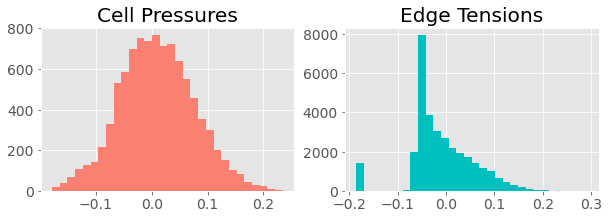

In [33]:
c_pres = torch.cat([d.cell_pressures for d in vtxdata],0)
e_tens = torch.cat([d.edge_tensions for d in vtxdata],0)

print(f'> Cell Pressures\n\trange: [{c_pres.min():4.3g} {c_pres.max():4.3g}]; s.d.: {c_pres.std():4.3g} ||'+
      f' median: {c_pres.median():4.3g}; mean: {c_pres.mean():4.3g};')
print(f'> Edge Tensions\n\trange: [{e_tens.min():4.3g} {e_tens.max():4.3g}]; s.d.: {e_tens.std():4.3g} ||'+
      f' median: {e_tens.median():4.3g}; mean: {e_tens.mean():4.3g};')

plt.figure(figsize=[10,3])
ax1 = plt.subplot(1,2,1)
ax1.hist(c_pres.view(-1,).numpy(),bins=30,color='salmon');
ax1.set_title('Cell Pressures')

ax2 = plt.subplot(1,2,2)
ax2.hist(e_tens.view(-1,).numpy(),bins=30,color='c');
ax2.set_title('Edge Tensions');

In [2]:
# data.is_undirected()

In [1]:
# nx.draw(to_networkx(data),pos=dict(enumerate(data.pos.numpy())), node_size=60)

In [44]:
# in order to track the batch id for var-s add its key to "follow_batch":
loader = DataLoader(vtxdata, batch_size=2,follow_batch=['cell_pressures','edge_index'])
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids
batch = next(iter(loader))
# nx.draw( to_networkx(
#     CellData(num_nodes = torch.sum(batch.batch==0).item(),
#              edge_index = batch.edge_index[:,batch.edge_index_batch==0])),
#     pos=dict(enumerate(batch.pos[batch.batch==0].numpy())),
#     node_size=60, node_color='r',edge_color='r')
# nx.draw( to_networkx(
#     CellData(num_nodes = torch.sum(batch.batch==1).item(),
#              edge_index = batch.edge_index[:,batch.edge_index_batch==1]-240)),
#     pos=dict(enumerate(batch.pos[batch.batch==1].numpy() +1.5)),
#     node_size=60)
batch

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], cell_pressures_batch=[200], edge_attr=[678, 2], edge_index=[2, 678], edge_index_batch=[678], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])

## Training

**Training Loop**

In [ ]:
# useful functions for model training and saving, etc.
import time
import copy
import torch

def train_model(model,
                optimizer,
                data_loaders,
                num_epochs = 5,
                loss_func = torch.nn.CrossEntropyLoss(),
                device = torch.device('cpu'),
                scheduler = None,
                return_best = False,
               classifier=None):
    '''
    docs
    '''
    # model states/modes
    model_states = ['train', 'val']
    training_model=model
    if classifier!=None:
        training_model=classifier # transfer learning
    
    curve_data = {'trainLosses':[],
                 'trainAccs':[],
                 'valLosses':[],
                 'valAccs':[],
                 'total_epochs':num_epochs}
    
    time_start = time.time()
    if return_best:
        best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1} ---', end=' ')
        
        # set model state depending on training/eval stage
        for state in model_states:
            if state == 'train':
                training_model.train()  # Set model to training mode
            else:
                training_model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for samples in data_loaders[state]:
                # input HxW depend on transform function(s), 3 Channels
                inputs = samples['image'].to(device)
                # labels \in [0, 1, 2]
                labels = samples['label'].to(device)          
                
                # set grad accumulator to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(state == 'train'):
                    # grad tracking is disabled in "eval" mode
                    outputs = model(inputs) # output:(batch, #classes)
                    _, preds = torch.max(outputs, 1) # labels:(batch,)
                    loss = loss_func(outputs, labels) #<-torch.nn.CrossEntropyLoss
                    
                    if state == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # weighted loss
                running_corrects += torch.sum(preds == labels.detach() )
            
                # apply LR schedule
                if state == 'train' and scheduler!=None:
                    scheduler.step()

            epoch_loss = running_loss / len(data_loaders[state].dataset)
            epoch_acc = running_corrects.double() / len(data_loaders[state].dataset)
            
            curve_data[f'{state}Losses'].append(epoch_loss)
            curve_data[f'{state}Accs'].append(epoch_acc)
            
            print(f'{state} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}',end=' || ')
            
            # deep copy the model
            if state == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                if return_best:
                    # keep best weights to return
                    best_model_wts = copy.deepcopy(model.state_dict())
        print(f'{time.time() - time_start:.0f}s')
    time_elapsed = time.time() - time_start
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} (return best:{return_best})')
    
    if return_best:
        # load best model weights
        model.load_state_dict(best_model_wts)
    
    return model, curve_data


@torch.no_grad()
def predict_check(data_loaders, model,device=torch.device('cpu')):
    '''
    Run prediction on datasets using dataloader
    - data_loaders: data loaders (dict of torch.utils.data.DataLoader objects) with
                    keys 'train' and 'val', for training and validation data loaders respectively.
                    ! DISABLE SHUFFLING in both datasets in order to preserve order of IDs
    - model: model used for prediction
    - device: device, e.g. "torch.device('cuda')"
    '''
    loss_func = torch.nn.CrossEntropyLoss()
    losses = {'train':0, 'val': 0}
    accuracies = {'train':0, 'val':0}
    pred_labels = {'train':[],'val':[]}
    
    model.eval()
    default_device = next(model.parameters()).device
    model.to(device)
    for loader_type in data_loaders:
        print(f'Loading: {loader_type}')
        for samples in data_loaders[loader_type]:
            inputs = samples['image'].to(device) # input images
            labels = samples['label'].to(device) # labels \in [0, 1, 2]       
            # predict
            outputs = model(inputs) # output:(batch, #classes)
            _, preds = torch.max(outputs, 1) # labels:(batch,)
            preds = preds.cpu()
            loss = loss_func(outputs, labels) #<-torch.nn.CrossEntropyLoss
            losses[loader_type] += loss.item() * inputs.size(0) # weighted loss
            accuracies[loader_type] += torch.sum(preds == labels.cpu() )
            pred_labels[loader_type].extend(preds.tolist())
            
        losses[loader_type] = losses[loader_type] / len(data_loaders[loader_type].dataset)
        accuracies[loader_type] = accuracies[loader_type] / len(data_loaders[loader_type].dataset)
    print('Losses:',losses)
    print('Accuracies:', accuracies)
    
    model.to(default_device)
    return losses, accuracies, pred_labels




In [ ]:
@torch.no_grad()
def predict_test(root_path, model, transform, batch_size=4, device=torch.device('cpu')):
    '''Run prediction on test images.
    - root_path: path to the folder with test images
    - model: model used for prediction 
    - batch_size: batch size for processing
    - device: device, e.g. "torch.device('cuda')"
    '''
    model.eval()
    model.to(device)
    # list of test image files
    test_image_names= [path.split(imgname)[-1] for imgname in glob.glob(path.join(root_path,'*.png'))]
    # sort according to image ID number
    test_image_names.sort(key=lambda x: int(x.split('.')[0]))
    ID = [int(imgname.split('.')[0]) for imgname in test_image_names]
    N_samples = len(test_image_names)
    print(f'Found {N_samples} images in test dataset folder: {path.join(*path.split(root_path)[:-1])}'+
          f'\n\"{test_image_names[0]}\"\n\"{test_image_names[1]}\"\n\"{test_image_names[2]}\"\n. . .\n'+
          f'\"{test_image_names[-3]}\"\n\"{test_image_names[-2]}\"\n\"{test_image_names[-1]}\"]\n')
    
    # iter over batches
    pred_labels = []
    N_batches = N_samples//batch_size + (1 if N_samples%batch_size else 0)
    print(f'Processing {N_batches} test batches in total (batch_size={batch_size}).')
    for b in range(N_batches):
        last_idx = min([b*batch_size+batch_size,N_samples])
        # read and transform images
        img_batch = torch.stack([transform( imread(path.join(root_path,imgname)) )
                     for imgname in test_image_names[b*batch_size:last_idx]],dim=0)
        img_batch = img_batch.to(device)
        # predict
        outputs = model(img_batch) # output:(batch, #classes)
        _, preds = torch.max(outputs, 1) # labels:(batch,)
        preds = preds.cpu()
        pred_labels.extend(preds.tolist())
    print('Done.')
    return {'ID': ID, 'Label': pred_labels}
